<center><img src="../logo.png" alt="drawing" width="400" style="background-color:white; padding:1em;" /></center> <br/>

# Application of Deep Learning to Text and Image Data
## Module 2, Lab 5: Finetuning BERT


BERT stands for **B**idirectional **E**ncoder **R**epresentations from **T**ransformers. To learn how BERT works, let's fine-tune the __BERT__ model to classify product reviews. You will use a new library called __transformers__ to download a pre-trained BERT model. 

You will learn:

- How to load and format the dataset
- How to load the pre-trained model
- How to train and test the model

__BERT and its variants use more resources than the other models you have used so far. This may cause your instance to run out of memory. If that happens:__

- Restart the kernel (Kernel->Restart from the top menu)
- Reduce the batch size 
- Then re-run the code



__Note__: In this walkthrough, you will use a light version of the original BERT implementation called __"DistilBert"__. You can checkout [the paper](https://arxiv.org/pdf/1910.01108.pdf) about it for more details. 

---
This lab uses a dataset derived from a small sample of Amazon product reviews. 

__Review dataset schema:__
* __reviewText:__ Text of the review
* __summary:__ Summary of the review
* __verified:__ Whether the purchase was verified (True or False)
* __time:__ UNIX timestamp for the review
* __log\_votes:__ Logarithm-adjusted votes log(1+votes)
* __isPositive:__ Whether the review is positive or negative (1 or 0)


---

You will be presented with two kinds of exercises throughout the notebook: activities and challenges. <br/>

| <img style="float: center;" src="../activity.png" alt="Activity" width="125"/>| <img style="float: center;" src="../challenge.png" alt="Challenge" width="125"/>|
| --- | --- |
|<p style="text-align:center;">No coding is needed for an activity. You try to understand a concept, <br/>answer questions, or run a code cell.</p> |<p style="text-align:center;">Challenges are where you can practice your coding skills.</p> |


## Index

1. [Reading and formatting the dataset](#Reading-and-formatting-the-dataset)
1. [Loading the pre-trained model](#Loading-the-pre-trained-model)
1. [Training and testing the model](#Training-and-testing-the-model)
1. [Getting predictions on the test data](#Getting-predictions-on-the-test-data)

In [1]:
!pip install -U -q -r requirements.txt

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autovizwidget 0.21.0 requires pandas<2.0.0,>=0.20.1, but you have pandas 2.0.3 which is incompatible.
hdijupyterutils 0.21.0 requires pandas<2.0.0,>=0.17.1, but you have pandas 2.0.3 which is incompatible.
sparkmagic 0.21.0 requires pandas<2.0.0,>=0.17.1, but you have pandas 2.0.3 which is incompatible.


## Reading and formatting the dataset

First, you need to read in the product review dataset and prepare it for the BERT model. To keep the training time down, you will only use the first 2000 data points from the dataset. If you want to improve your model after you understand how to train, you can use more data to train a new model.

In [2]:
import os
import sys
import time
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast
from torch.utils.data import DataLoader

# Import system library and append path
sys.path.insert(1, '..')

# Setting tokenizer parallelism to false
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Import utility functions that provide answers to challenges
from MLUDTI_EN_M2_Lab5_quiz_questions import *

### Read the dataset.

In [3]:
df = pd.read_csv("data/NLP-REVIEW-DATA-CLASSIFICATION-TRAINING.csv")

### Print the dataset information to see the field types.

In [4]:
df

,ID,reviewText,summary,verified,time,log_votes,isPositive
0,65886,Purchased as a quick fix for a needed Server 2...,"Easy install, seamless migration",True,1458864000,0.000000,1
1,19822,So far so good. Installation was simple. And r...,Five Stars,True,1417478400,0.000000,1
2,14558,Microsoft keeps making Visual Studio better. I...,This is the best development tool I've ever used.,False,1252886400,0.000000,1
3,39708,Very good product.,Very good product.,True,1458604800,0.000000,1
4,8015,So very different from my last version and I a...,... from my last version and I am having a gre...,True,1454716800,2.197225,0
...,...,...,...,...,...,...,...
55995,41354,"I like the program, but hate it's help section...","If only it's help wasn't so poor, it would be ...",True,1374364800,0.000000,0
55996,36874,I have been editing for years using Pinnacle p...,Just not for me,True,1425859200,0.000000,0
55997,67979,After purchasing a new Dell desktop with Win 7...,Microsoft Powerpoint 2010 Problem (Solved),True,1282176000,3.044522,1
55998,35218,Re Microsoft Streets and Trips 2007:\n\nThink ...,"Disappointed, but few other options exist",True,1165104000,2.708050,0


### You do not need any of the rows that do not have __reviewText__, so drop them.

In [5]:
df.dropna(subset=["reviewText"], inplace=True)
df.shape

(55989, 7)

<div style="border: 4px solid coral; text-align: center; margin: auto;">
    <h2><i>Try it Yourself!</i></h2>
    <br>
    <p style="text-align:center;margin:auto;"><img src="../activity.png" alt="Activity" width="100" /> </p>
    <p style=" text-align: center; margin: auto;">Answer the question below to test your understanding of epochs and learning rate.</p>
    <br>
</div>

In [3]:
#question_1

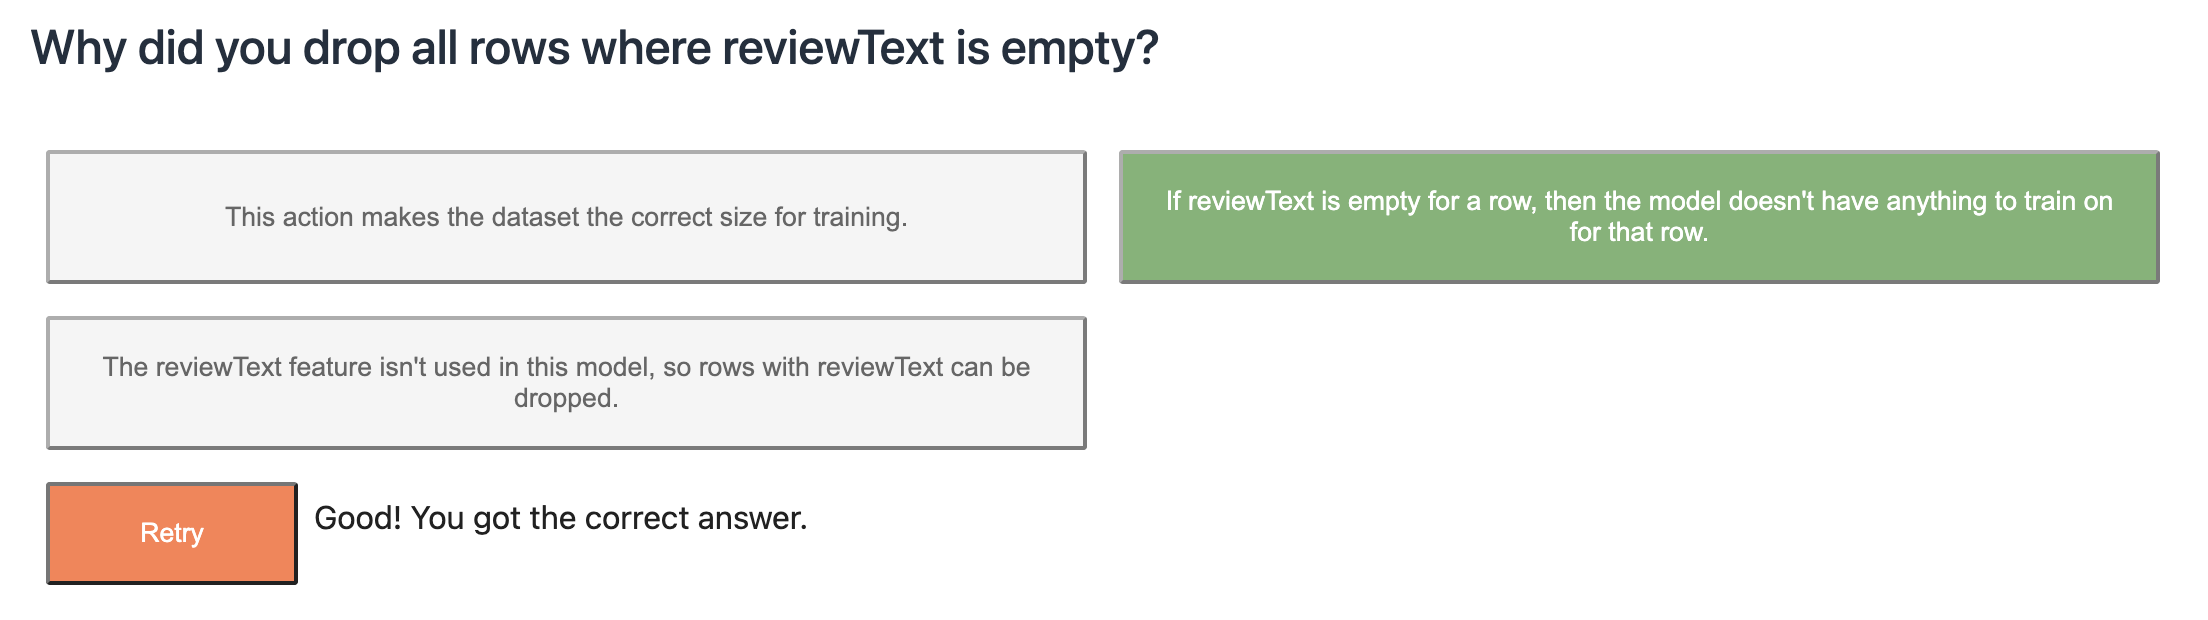

### BERT requires a lot of compute power for large datasets. To reduce the amount of time it takes to train the model, you will only use the first 2,000 data points for this lab. 

In [7]:
df = df.head(2000)

### Now split the dataset into training and validation data sets, keeping 10% of the data for validation.

In [8]:
# This separates 10% of the entire dataset into validation dataset.
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["reviewText"].tolist(),
    df["isPositive"].tolist(),
    test_size=0.10,
    shuffle=True,
    random_state=324,
    stratify = df["isPositive"].tolist(),
)

### You need to tokenize the data. To do this, use a special tokenizer built for the DistilBERT model to tokenize the training and validation texts. 

In [9]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(train_texts,
                            truncation=True,
                            padding=True)
val_encodings = tokenizer(val_texts,
                          truncation=True,
                          padding=True)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

### Create a new `ReviewDataset` class to use with the BERT model. Later, you use the training and validation encoding-label pairs with this new class.

In [18]:
class ReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]).to(device) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx]).to(device)
        return item

    def __len__(self):
        return len(self.labels)
    
train_dataset = ReviewDataset(train_encodings, train_labels)
val_dataset = ReviewDataset(val_encodings, val_labels)

## Loading the pre-trained model

Now, you need to load the model. When you do this, several warnings will print that are related to the last classification layer of BERT where you are using a randomly initialized layer. You can ignore the warnings as they are not relevant to the type of training you are doing.

In [31]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased",
                                                            num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### The last step is to freeze all weights until the very last classification layer in the BERT model.
This helps accelerate the training process. Training the weights of the whole network (66 million weights) takes a long time. Additionally, 2000 data points would not be enough for that task. Instead, the code below freezes all the weights until the last classification layer. This means only a small portion of the weights gets updated (rest stays the same). This is a common practice with large language models.

In [32]:
# Freeze the encoder weights until the classifier
for name, param in model.named_parameters():
    if "classifier" not in name:
        param.requires_grad = False

## Training and testing the model

Now that your data is ready and you have configured your model, its time to start the fine-tuning process. This code will take __a long time__ (30+ minutes) to complete with large datasets, that is why you are running it on a subset of the full review dataset.

#### First, define the accuracy function.

In [33]:
def calculate_accuracy(output, label):
    """Calculate the accuracy of the trained network. 
    output: (batch_size, num_output) float32 tensor
    label: (batch_size, ) int32 tensor """
    
    return (output.argmax(axis=1) == label.float()).float().mean()

#### Now you need to create the training and validation loop.
This loop will be similar to the previous train/validation loops, however there are a few extra parameters needed due to the transformer architecture. 

You need to use the `attention_mask` and get the loss from the output of the model with `loss = output[0]`

In [34]:
# Hyperparameters
num_epochs = 10
learning_rate = 0.005

# Get the compute device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create data loaders
train_loader = DataLoader(train_dataset, shuffle=True,
                          batch_size=16, drop_last=True)
validation_loader = DataLoader(val_dataset, batch_size=8,
                               drop_last=True)

# Setup the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

model = model.to(device)

train_losses = []
train_accs = []
val_losses = []
valid_accs = []

run_start = time.time()

for epoch in range(num_epochs):
    
    train_loss, val_loss, train_acc, valid_acc = 0., 0., 0., 0.
    
    start = time.time()
    # Training loop starts
    model.train() # put the model in training mode
    for batch in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Put data, label and attention mask to the correct device
        data = batch["input_ids"].to(device)
        attention_mask = batch['attention_mask'].to(device)
        label = batch["labels"].to(device)
        
        # Make forward pass
        output = model(data, attention_mask=attention_mask, labels=label)
        
        # Calculate the loss (this comes from the output)
        loss = output[0]
        # Make backwards pass (calculate gradients)
        loss.backward()
        # Accumulate training accuracy and loss
        train_acc += calculate_accuracy(output.logits, label).item()
        train_loss += loss.item()
        # Update weights
        optimizer.step()
    
    # Validation loop:
    # This loop tests the trained network on validation dataset
    # No weight updates here
    # torch.no_grad() reduces memory usage when not training the network
    model.eval() # Activate evaluation mode
    with torch.no_grad():
        for batch in validation_loader:
            data = batch["input_ids"].to(device)
            attention_mask = batch['attention_mask'].to(device)
            label = batch["labels"].to(device)
            # Make forward pass with the trained model so far
            output = model(data, attention_mask=attention_mask, labels=label)
            # Accumulate validation accuracy and loss
            valid_acc += calculate_accuracy(output.logits, label).item()
            val_loss += output[0].item()
        
    # Take averages
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    val_loss /= len(validation_loader)
    valid_acc /= len(validation_loader)
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    valid_accs.append(valid_acc)
    
    end = time.time()
    
    print("Epoch %d: train loss %.3f, train acc %.3f, val loss %.3f, val acc %.3f, seconds % .3f " % (
        epoch+1, train_loss, train_acc, val_loss, valid_acc, end-start))

print("Run duration:", end - run_start, "seconds")

Epoch 1: train loss 0.656, train acc 0.614, val loss 0.637, val acc 0.620, seconds  29.517 
Epoch 2: train loss 0.630, train acc 0.625, val loss 0.610, val acc 0.620, seconds  29.645 
Epoch 3: train loss 0.610, train acc 0.649, val loss 0.586, val acc 0.635, seconds  29.724 
Epoch 4: train loss 0.588, train acc 0.685, val loss 0.562, val acc 0.655, seconds  29.751 
Epoch 5: train loss 0.563, train acc 0.730, val loss 0.552, val acc 0.635, seconds  29.760 
Epoch 6: train loss 0.543, train acc 0.744, val loss 0.511, val acc 0.760, seconds  29.744 
Epoch 7: train loss 0.519, train acc 0.767, val loss 0.486, val acc 0.805, seconds  29.770 
Epoch 8: train loss 0.495, train acc 0.785, val loss 0.463, val acc 0.805, seconds  29.757 
Epoch 9: train loss 0.481, train acc 0.790, val loss 0.445, val acc 0.810, seconds  29.726 
Epoch 10: train loss 0.464, train acc 0.803, val loss 0.427, val acc 0.845, seconds  29.758 
Run duration: 297.1546792984009 seconds


In [35]:
train_losses, train_accs, val_losses, valid_accs

([0.6561266042824302,
  0.6299898541931596,
  0.6101461891084909,
  0.5877431003110749,
  0.5634346237140042,
  0.5425900258123875,
  0.5186963528394699,
  0.4954894528325115,
  0.48063932944621357,
  0.464323490858078],
 [0.6138392857142857,
  0.625,
  0.6489955357142857,
  0.6852678571428571,
  0.7299107142857143,
  0.7444196428571429,
  0.7672991071428571,
  0.7845982142857143,
  0.7896205357142857,
  0.8030133928571429],
 [0.6368665730953217,
  0.6104119527339935,
  0.5860969197750091,
  0.5615304815769195,
  0.5515250885486602,
  0.5107833874225617,
  0.4860823082923889,
  0.4629523801803589,
  0.44536055862903595,
  0.4270703279972076],
 [0.62, 0.62, 0.635, 0.655, 0.635, 0.76, 0.805, 0.805, 0.81, 0.845])

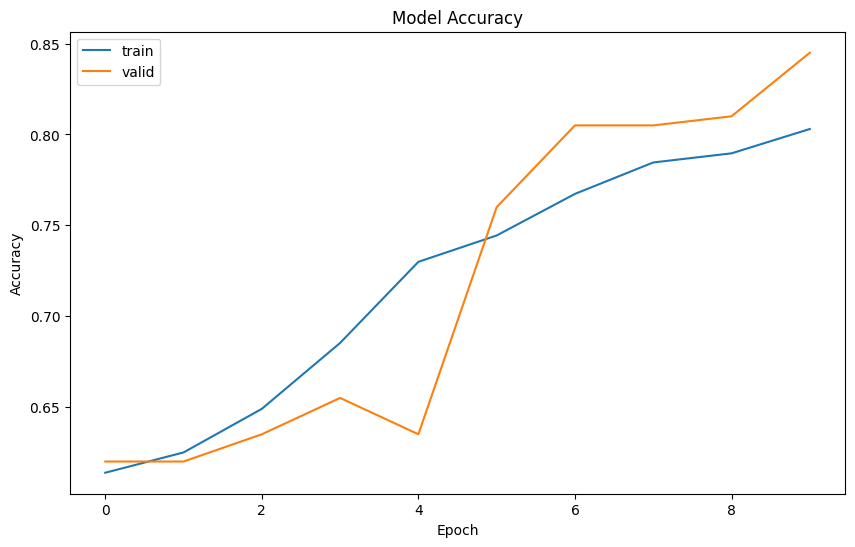

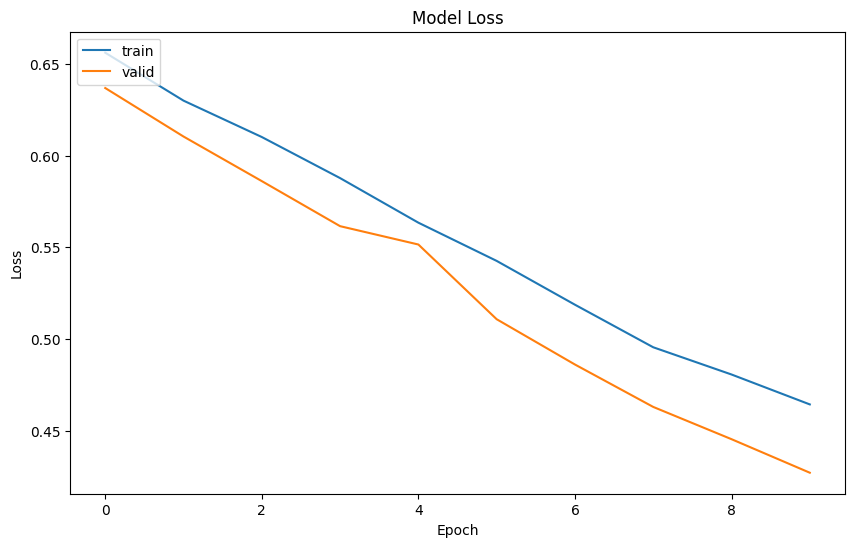

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline
# list all data in training
# print(model.history.keys())
# summarize training for accuracy
plt.figure(figsize=(10, 6))
plt.plot(train_accs)
plt.plot(valid_accs)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize traning for loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses)
plt.plot(val_losses)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

### Looking at what's going on

The fine-tuned BERT model is able to correctly classify the sentiment of the most of the records in the validation set. Let's observe in more detail how the sentences are tokenized and encoded. You can do this by picking one sentence as example to look at.

In [38]:
st = val_texts[19]
print(f"Sentence: {st}")
tok = tokenizer(st, truncation=True, padding=True)
print(f"Encoded Sentence: {tok['input_ids']}")

Sentence: An excellent resource for all scanner owners.  Seems to be up to date and all inclusive.  I highly recommend this product!
Encoded Sentence: [101, 2019, 6581, 7692, 2005, 2035, 26221, 5608, 1012, 3849, 2000, 2022, 2039, 2000, 3058, 1998, 2035, 18678, 1012, 1045, 3811, 16755, 2023, 4031, 999, 102]


### Print the vocabulary size.

In [39]:
# The mapped vocabulary is stored in tokenizer.vocab
tokenizer.vocab_size

30522

### Use the encoded sentence with the tokenizer to recover the original sentence. 

In [40]:
# Methods convert_ids_to_tokens and convert_tokens_to_ids allow to see how sentences are tokenized
print(tokenizer.convert_ids_to_tokens(tok["input_ids"]))

['[CLS]', 'an', 'excellent', 'resource', 'for', 'all', 'scanner', 'owners', '.', 'seems', 'to', 'be', 'up', 'to', 'date', 'and', 'all', 'inclusive', '.', 'i', 'highly', 'recommend', 'this', 'product', '!', '[SEP]']


## Getting predictions on the test data

After the model is trained, you can focus on getting test data to make predictions with. Do this by:
- Reading and format the test dataset
- Passing the test data to your trained model and make predictions

In [42]:
# Read the test data (It doesn't have the isPositive label)
df_test = pd.read_csv("data/NLP-REVIEW-DATA-CLASSIFICATION-TEST.csv")
df_test

,ID,reviewText,summary,verified,time,log_votes
0,33276,I've been using greeting card software for wel...,Absolutely awful.,False,1300233600,0.000000
1,20859,"This version worked well for me, have upgraded...",Good for virtual machine on a mac,True,1448755200,0.000000
2,63500,Great!,Five Stars,True,1456963200,0.000000
3,4950,I can assure you that any five star review was...,SCAM,False,1400803200,2.197225
4,26509,Overall the product really seems the same but ...,Has potential but many glitches and really the...,False,1419206400,0.000000
...,...,...,...,...,...,...
13995,61759,It was working for awhile.. but it started to ...,and everything is working fine!,False,1465430400,0.000000
13996,67654,Turbo tax is easy to use and complete.,Five Stars,True,1425340800,0.000000
13997,53439,"This is an excellent program, much better than...",Excellent Program,False,1410134400,0.000000
13998,49347,PLEASE NOTE THAT THERE IS NO RETURN AND THIS D...,PLEASE NOTE THAT THERE IS NO RETURN AND THIS D...,True,1520553600,0.000000


### Just as before, drop the rows that don't have the __reviewText__.

In [44]:
df_test.dropna(subset=["reviewText"], inplace=True)
df_test.shape

(13999, 6)

### Making predictions will also take a long time with this model.
To get results quickly, start by only making predictions with 15 datapoints from the test set.

In [45]:
test_texts = df_test["reviewText"].tolist()[0:15]

In [46]:
test_encodings = tokenizer(test_texts,
                           truncation=True,
                           padding=True)

### Create labels for the test dataset to pass zeros using `[0]*len(test_texts)`.

In [47]:
test_dataset = ReviewDataset(test_encodings, [0]*len(test_texts))

### Then, create a dataloader for the test set and record the corresponding predictions.

In [48]:
test_loader = DataLoader(test_dataset, batch_size=4)
test_predictions = []
model.eval()

with torch.no_grad():
    for batch in test_loader:
        data = batch["input_ids"].to(device)
        attention_mask = batch['attention_mask'].to(device)
        label = batch["labels"].to(device)
        output = model(data, attention_mask=attention_mask, labels=label)
        predictions = torch.argmax(output.logits, dim=-1)
        test_predictions.extend(predictions.cpu().numpy())

### Finally, pick an example sentence and examine the prediction. Does the prediction look correct? 

Remember 

- 1->positive class 
- 0->negative class

In [49]:
k = 13
print(f'Text: {test_texts[k]}')
print(f'Prediction: {test_predictions[k]}')

Text: I have been using this product for five or six years.  This purchase was my annual subscription renewal.  It has the features that I need, and seems to protect the three PC's that we have while using the internet.  I will be looking at the mobile apps for a tablet and smart phone.
Prediction: 1


<div style="border: 4px solid coral; text-align: center; margin: auto;">
    <h2><i>Try it Yourself!</i></h2>
    <br>
    <p style="text-align:center; margin:auto;"><img src="../challenge.png" alt="Challenge" width="100" /> </p>
    <p style="margin: auto; text-align: center; margin: auto;">You trained the model for 10 epochs. Would you get better results from the validation dataset if the model trained longer?</p> <br>
    <p style="margin: auto; text-align: center; margin: auto;">Make a note of your last <code> Val_loss </code> result.</p> 
    <p style="margin: auto; text-align: center; margin: auto;">Then, in the <a href="#Training-and-testing-the-model">Training and testing the model</a> section, change the <code> num_epochs </code> parameter to <code>20</code>.</p>
    <p style="margin: auto; text-align: center; margin: auto;">Finally, re-run the code blocks to load the pre-trained model, and train your model.</p>
    <p style="margin: auto; text-align: center; margin: auto;">Did <code>Val_loss</code> improve?</p>
    </ol>    
</div>

In [52]:
def set_model():
    return DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased",
                                                                num_labels=2)

In [51]:
# Freeze the encoder weights until the classifier
def freeze_weights(model):
    for name, param in model.named_parameters():
        if "classifier" not in name:
            param.requires_grad = False

In [54]:
def train_and_val(model, train_dataset, val_dataset, num_epochs = 10, learning_rate = 0.005):
    # Get the compute device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Create data loaders
    train_loader = DataLoader(train_dataset, shuffle=True,
                              batch_size=16, drop_last=True)
    validation_loader = DataLoader(val_dataset, batch_size=8,
                                   drop_last=True)

    # Setup the optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    model = model.to(device)

    train_losses = []
    train_accs = []
    val_losses = []
    valid_accs = []

    run_start = time.time()

    for epoch in range(num_epochs):

        train_loss, val_loss, train_acc, valid_acc = 0., 0., 0., 0.

        start = time.time()
        # Training loop starts
        model.train() # put the model in training mode
        for batch in train_loader:
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Put data, label and attention mask to the correct device
            data = batch["input_ids"].to(device)
            attention_mask = batch['attention_mask'].to(device)
            label = batch["labels"].to(device)

            # Make forward pass
            output = model(data, attention_mask=attention_mask, labels=label)

            # Calculate the loss (this comes from the output)
            loss = output[0]
            # Make backwards pass (calculate gradients)
            loss.backward()
            # Accumulate training accuracy and loss
            train_acc += calculate_accuracy(output.logits, label).item()
            train_loss += loss.item()
            # Update weights
            optimizer.step()

        # Validation loop:
        # This loop tests the trained network on validation dataset
        # No weight updates here
        # torch.no_grad() reduces memory usage when not training the network
        model.eval() # Activate evaluation mode
        with torch.no_grad():
            for batch in validation_loader:
                data = batch["input_ids"].to(device)
                attention_mask = batch['attention_mask'].to(device)
                label = batch["labels"].to(device)
                # Make forward pass with the trained model so far
                output = model(data, attention_mask=attention_mask, labels=label)
                # Accumulate validation accuracy and loss
                valid_acc += calculate_accuracy(output.logits, label).item()
                val_loss += output[0].item()

        # Take averages
        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        val_loss /= len(validation_loader)
        valid_acc /= len(validation_loader)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        valid_accs.append(valid_acc)

        end = time.time()

        print("Epoch %d: train loss %.3f, train acc %.3f, val loss %.3f, val acc %.3f, seconds % .3f " % (
            epoch+1, train_loss, train_acc, val_loss, valid_acc, end-start))

    print("Run duration:", end - run_start, "seconds")
    return train_losses, train_accs, val_losses, valid_accs

In [55]:
def chart_results(train_losses, train_accs, val_losses, valid_accs):
    # summarize training for accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(train_accs)
    plt.plot(valid_accs)
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()
    # summarize traning for loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses)
    plt.plot(val_losses)
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1: train loss 0.653, train acc 0.617, val loss 0.627, val acc 0.620, seconds  29.320 
Epoch 2: train loss 0.627, train acc 0.632, val loss 0.603, val acc 0.620, seconds  29.502 
Epoch 3: train loss 0.601, train acc 0.662, val loss 0.586, val acc 0.785, seconds  29.568 
Epoch 4: train loss 0.581, train acc 0.705, val loss 0.552, val acc 0.675, seconds  29.619 
Epoch 5: train loss 0.557, train acc 0.736, val loss 0.527, val acc 0.720, seconds  29.647 
Epoch 6: train loss 0.536, train acc 0.755, val loss 0.503, val acc 0.765, seconds  29.672 
Epoch 7: train loss 0.516, train acc 0.770, val loss 0.480, val acc 0.805, seconds  29.710 
Epoch 8: train loss 0.493, train acc 0.785, val loss 0.462, val acc 0.780, seconds  29.737 
Epoch 9: train loss 0.474, train acc 0.792, val loss 0.441, val acc 0.830, seconds  29.753 
Epoch 10: train loss 0.455, train acc 0.803, val loss 0.426, val acc 0.810, seconds  29.744 
Epoch 11: train loss 0.443, train acc 0.812, val loss 0.408, val acc 0.825, sec

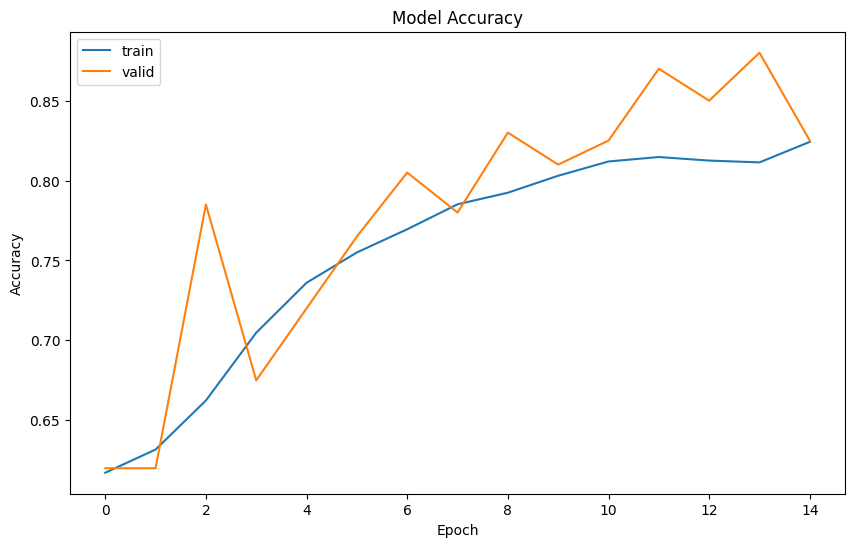

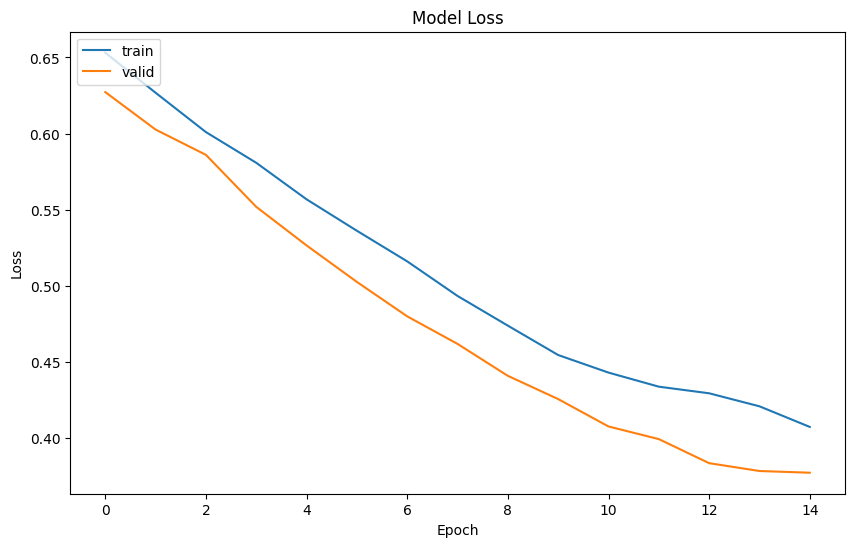

In [56]:
model = set_model()

freeze_weights(model)

train_losses, train_accs, val_losses, valid_accs = train_and_val(model, train_dataset, val_dataset, num_epochs = 15, learning_rate = 0.005)

chart_results(train_losses, train_accs, val_losses, valid_accs)

----
## Conclusion

In this lab you learned how to import a pre-trained Transformer model and fine-tune it for a specific task. Although you used a lighter version of the BERT model, these types of models tend to use large amounts of compute power. For that reason, you only worked with the first 2000 datapoints of the dataset. To see more general results, you need to spend more time training while using the whole dataset. 

## Next Lab: Reading and plotting images
In the next lab you will learn how to read images and plot them as you start to learn about computer vision problems.
